# Project 1 - Cat or Dogs ?

# 0 - Data/Libs

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

import torchvision.transforms as T

from sklearn.model_selection import train_test_split

In [2]:
PATH_TO_TRAINVAL_TXT = "dataset/annotations/trainval.txt"
PATH_TO_TEST_TXT = "dataset/annotations/test.txt"
PATH_TO_LIST_TXT = "dataset/annotations/list.txt"

PATH_TO_IMG = "dataset/images/" # .jpg
PATH_TO_TRIMAPS = "dataset/annotations/trimaps/" #.png

- 37 category pet dataset with roughly 200 images for each class
- Images have a large variations in scale, pose and lighting.
- All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.

# 1 - Data analysis

### Species distribution

In [3]:
# List all species names + type + number

pet_dict = {}

with open(PATH_TO_LIST_TXT, 'r') as f:
    for _ in range(6):
        next(f) #to skip the 6 first lines in list.txt

    for line in f:
        line = line.strip()
        if not line:
            continue #to skip empty lines if any

        class_id, id_, species, breed_id = line.split() #to retrieve the info from each line
        specie_name = "_".join(class_id.split("_")[:-1]) #to get the specie name only

        pet_dict[class_id] = {
            "class_id": class_id, # e.g. Abyssinian_100
            "id": int(id_), # 1:37 Class ids
            "species": int(species), # 1:Cat 2:Dog
            "breed_id": int(breed_id), # 1-25:Cat 1:12:Dog
            "specie_name": specie_name, # e.g. Abyssinian (without _100)
        }

#pet_dict
#specie_counts

In [4]:
df = pd.DataFrame.from_dict(pet_dict, orient="index")
df["species_label"] = df["species"].map({1: "Cat", 2: "Dog"})
df["img_path"] = df["class_id"].apply(lambda x: f"{PATH_TO_IMG}{x}.jpg")
df["trimap_path"] = df["class_id"].apply(lambda x: f"{PATH_TO_TRIMAPS}{x}.png")
df.head()

,class_id,id,species,breed_id,specie_name,species_label,img_path,trimap_path
Abyssinian_100,Abyssinian_100,1,1,1,Abyssinian,Cat,dataset/images/Abyssinian_100.jpg,dataset/annotations/trimaps/Abyssinian_100.png
Abyssinian_101,Abyssinian_101,1,1,1,Abyssinian,Cat,dataset/images/Abyssinian_101.jpg,dataset/annotations/trimaps/Abyssinian_101.png
Abyssinian_102,Abyssinian_102,1,1,1,Abyssinian,Cat,dataset/images/Abyssinian_102.jpg,dataset/annotations/trimaps/Abyssinian_102.png
Abyssinian_103,Abyssinian_103,1,1,1,Abyssinian,Cat,dataset/images/Abyssinian_103.jpg,dataset/annotations/trimaps/Abyssinian_103.png
Abyssinian_104,Abyssinian_104,1,1,1,Abyssinian,Cat,dataset/images/Abyssinian_104.jpg,dataset/annotations/trimaps/Abyssinian_104.png


In [5]:
df["species_label"].value_counts()

species_label
Dog    4978
Cat    2371
Name: count, dtype: int64

<Axes: ylabel='count'>

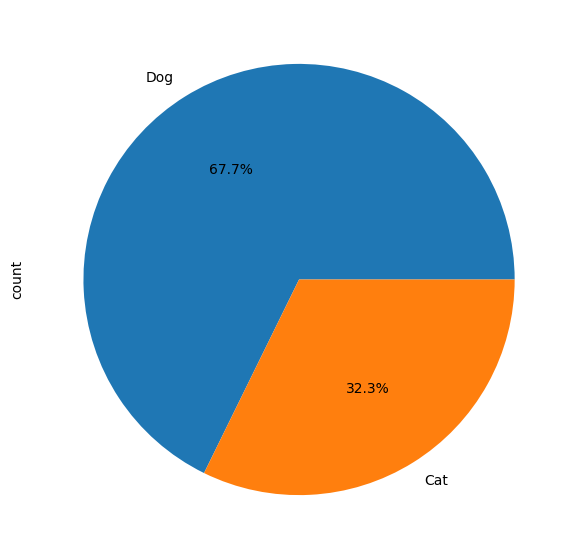

In [6]:
df["species_label"].value_counts().plot(kind="pie", autopct="%1.1f%%", figsize=(7,7))

<Axes: title={'center': 'Number of Pets per Species'}, xlabel='specie_name'>

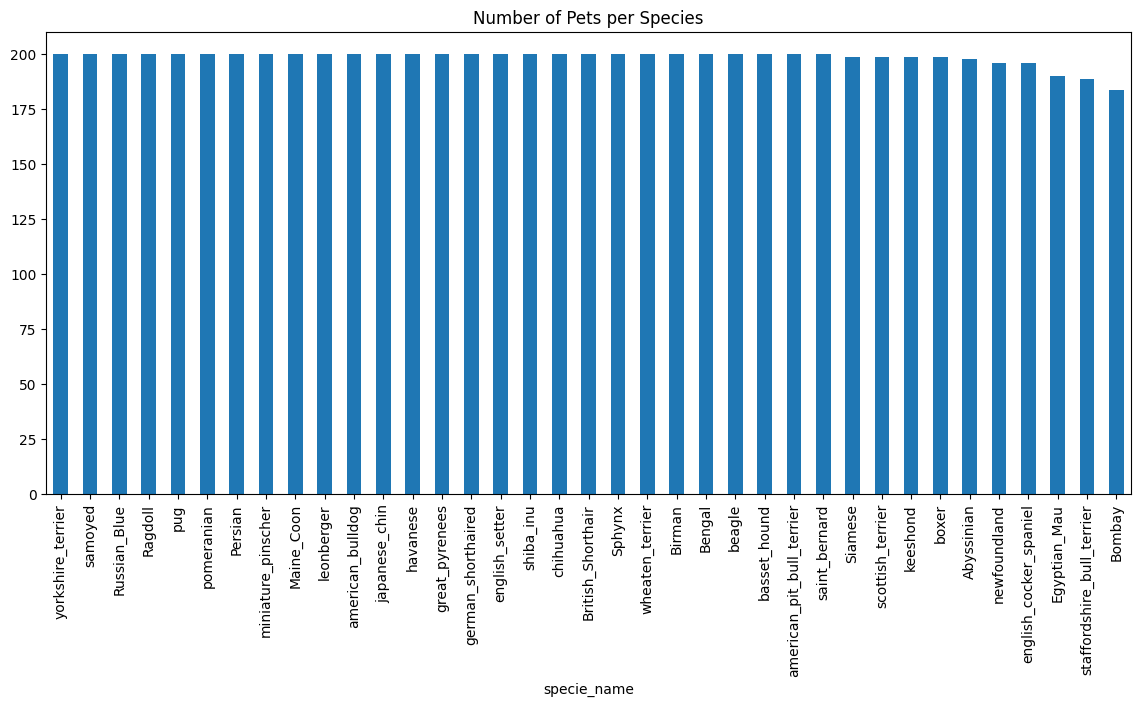

In [7]:
df["specie_name"].value_counts().plot(kind="bar", figsize=(14,6), rot=90, title="Number of Pets per Species")

<Axes: title={'center': 'Cat Species Distribution'}, ylabel='count'>

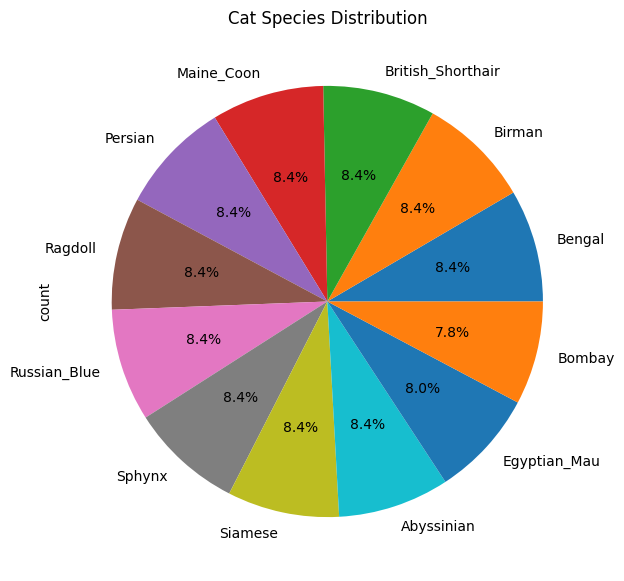

In [8]:
df[df["species"] == 1]["specie_name"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", figsize=(7,7), title="Cat Species Distribution"
)


<Axes: title={'center': 'Dog Species Distribution'}, ylabel='count'>

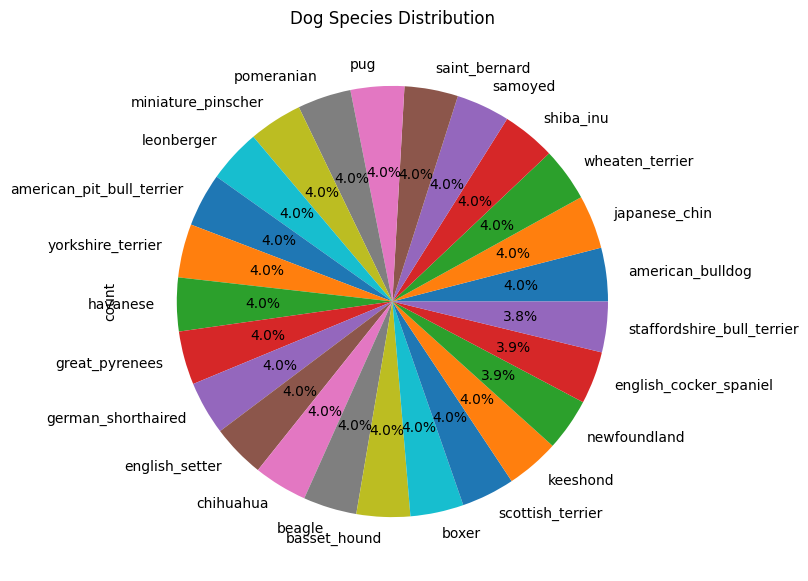

In [9]:
df[df["species"] == 2]["specie_name"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", figsize=(7,7), title="Dog Species Distribution"
)


------

### Image and Masks

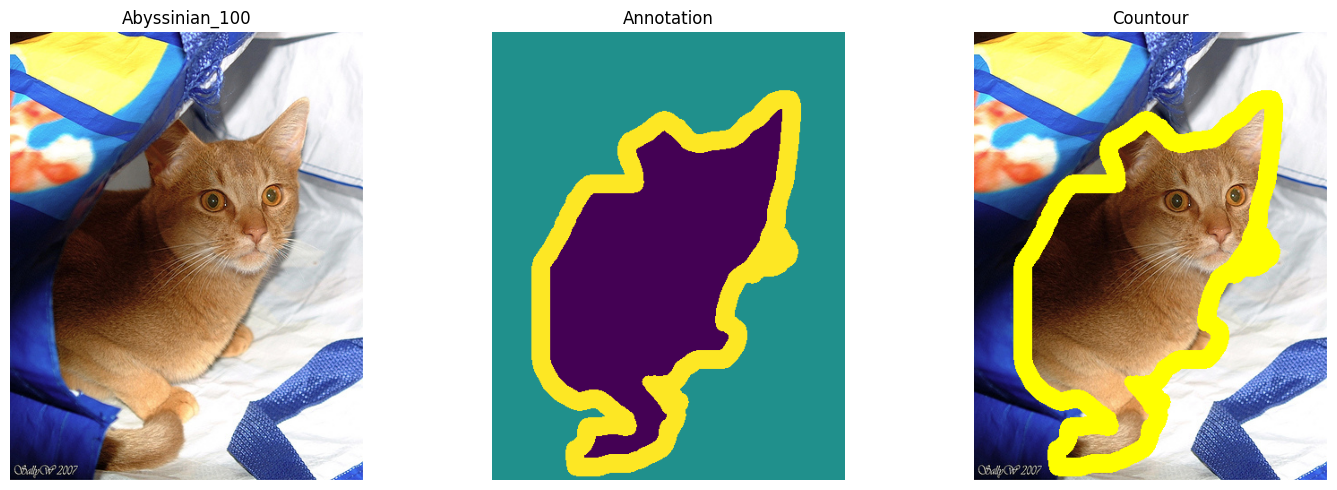

In [10]:
def show_image_annotation(class_id):
    row = df.loc[class_id] if class_id in df.index else df[df["class_id"] == class_id].iloc[0]

    img = Image.open(row["img_path"]).convert("RGB")
    ann = Image.open(row["trimap_path"])

    img_arr = np.array(img)
    ann_arr = np.array(ann)

    overlay = img_arr.copy()
    overlay[ann_arr == 3] = [255, 255, 0]

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(img)
    ax[0].set_title(row["class_id"])
    ax[0].axis("off")

    ax[1].imshow(ann_arr, cmap="viridis")
    ax[1].set_title("Annotation")
    ax[1].axis("off")

    ax[2].imshow(overlay)
    ax[2].set_title("Countour")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

show_image_annotation("Abyssinian_100")

In [11]:
def check_image_mask(df):
    missing_masks = []
    size_mismatch = []

    for idx, row in df.iterrows():
        img_path = row["img_path"]
        mask_path = row["trimap_path"]

        if not os.path.exists(mask_path):
            missing_masks.append((row["class_id"], mask_path))
            continue 
        
        img = Image.open(img_path)
        mask = Image.open(mask_path)

        if img.size != mask.size:
            size_mismatch.append((row["class_id"], img.size, mask.size))

    print("Image/Mask Check")
    print(f"Total samples: {len(df)}")
    print(f"Missing masks: {len(missing_masks)}")
    print(f"Size mismatches: {len(size_mismatch)}")
    print()

    if missing_masks:
        print("Missing masks:")
        for cid, path in missing_masks[:10]:
            print(f"  - {cid}: {path}")
        if len(missing_masks) > 10:
            print(f"  ... and {len(missing_masks) - 10} more.")
        print()

    if size_mismatch:
        print("Size mismatches (image vs mask):")
        for cid, img_size, mask_size in size_mismatch[:10]:
            print(f"  - {cid}: image={img_size}, mask={mask_size}")
        if len(size_mismatch) > 10:
            print(f"  ... and {len(size_mismatch) - 10} more.")

check_image_mask(df)



Image/Mask Check
Total samples: 7349
Missing masks: 0
Size mismatches: 0



In [12]:
def add_image_sizes(df):
    widths = []
    heights = []

    for path in df["img_path"]:
        img = Image.open(path)
        w, h = img.size
        widths.append(w)
        heights.append(h)

    df["width"] = widths
    df["height"] = heights

add_image_sizes(df)

In [13]:
df[["width", "height"]].describe()

,width,height
count,7349.000000,7349.000000
mean,437.237447,391.387264
std,115.775876,109.394560
min,114.000000,103.000000
25%,337.000000,333.000000
50%,500.000000,375.000000
75%,500.000000,500.000000
max,3264.000000,2606.000000


<Axes: title={'center': 'Width Distribution'}, ylabel='Frequency'>

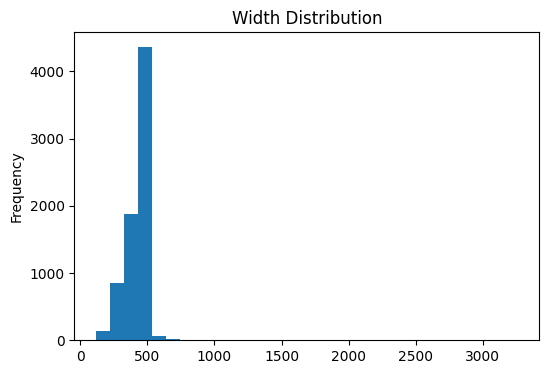

In [14]:
df["width"].plot(kind="hist", bins=30, figsize=(6,4), title="Width Distribution")

<Axes: title={'center': 'Height Distribution'}, ylabel='Frequency'>

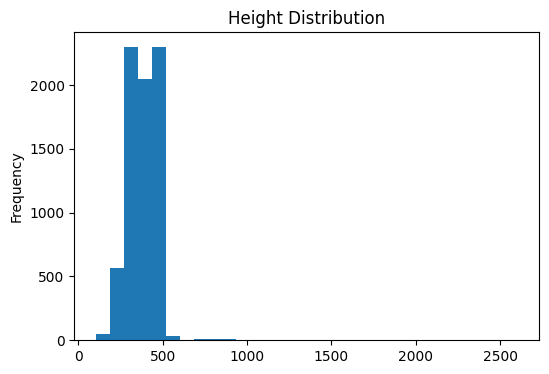

In [15]:
df["height"].plot(kind="hist", bins=30, figsize=(6,4), title="Height Distribution")

<Axes: title={'center': 'Width vs Height'}, xlabel='width', ylabel='height'>

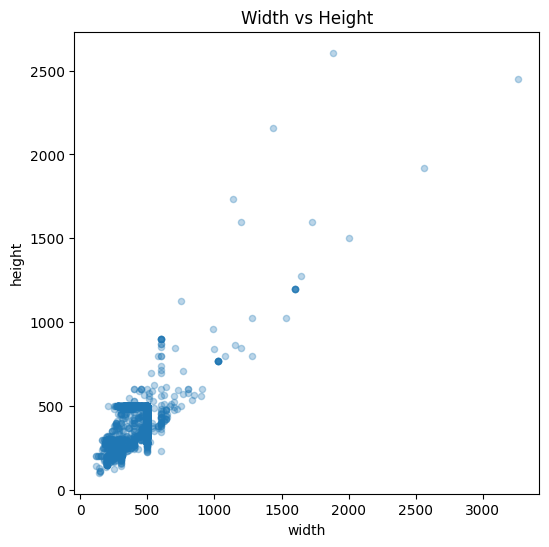

In [16]:
df.plot.scatter(x="width", y="height", alpha=0.3, figsize=(6,6), title="Width vs Height")

In [34]:
df.groupby(["width", "height"]).size().sort_values(ascending=False).head(20)


width  height
500    375       1424
       333       1069
375    500        511
333    500        509
300    225        261
500    334        250
       332        185
334    500        151
500    335         97
332    500         91
500    500         88
335    500         53
225    300         49
500    400         39
       281         29
       330         28
       376         27
400    500         27
500    374         27
357    500         26
dtype: int64

### TrainVal / Test Datasets

In [18]:
def load_split_file(path, img_root, mask_root):
    rows = []

    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()

            class_id = parts[0]           # Abyssinian_100
            id_      = int(parts[1])      # 1–37 (class id)
            species  = int(parts[2])      # 1=cat, 2=dog
            breed_id = int(parts[3])      # 1–25 cat, 1–12 dog
            specie_name = "_".join(class_id.split("_")[:-1])

            rows.append({
                "class_id": class_id,
                "id": id_,
                "species": species,
                "breed_id": breed_id,
                "specie_name": specie_name,
                "img_path": f"{img_root}/{class_id}.jpg",
                "trimap_path": f"{mask_root}/{class_id}.png",
            })

    return pd.DataFrame(rows)


In [19]:
trainval_df = load_split_file(
    "dataset/annotations/trainval.txt",
    img_root="dataset/images",
    mask_root="dataset/annotations/trimaps"
)

test_df = load_split_file(
    "dataset/annotations/test.txt",
    img_root="dataset/images",
    mask_root="dataset/annotations/trimaps"
)

# Binary label
trainval_df["label"] = trainval_df["species"].map({1: 0, 2: 1})  # 0=cat, 1=dog
test_df["label"] = test_df["species"].map({1: 0, 2: 1})


In [20]:
# Train / Val Separation

train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.2,
    stratify=trainval_df["label"],
    random_state=42,
)

In [21]:
# Do we use the mean/std of our dataset, or the ImageNet ones?
# --> We use ImageNet mean/std  because we might use pre-trained models later ??


In [22]:
## Data transformations

train_transform = T.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(p=0.5), #basic augm 
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225]),
])

val_transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225]),
])


### Custom Dataset : Dataframe <-> DataLoader

In [23]:
from torch.utils.data import Dataset


class PetsClassificationDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img = Image.open(row["img_path"]).convert("RGB")
        label = int(row["label"])  # 0=cat, 1=dog

        if self.transform:
            img = self.transform(img)

        return img, label

### DataLoader

In [24]:
from torch.utils.data import DataLoader

train_ds = PetsClassificationDataset(train_df, transform=train_transform)
val_ds   = PetsClassificationDataset(val_df,   transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)

In [25]:
print("Train size:", len(train_df))
print("Val size:", len(val_df))

Train size: 2944
Val size: 736


### CNN (Simple Version)

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)  # binary classif

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 64×64
        x = self.pool(F.relu(self.conv2(x)))  # 32×32
        x = self.pool(F.relu(self.conv3(x)))  # 16×16

        x = x.view(x.size(0), -1)             
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x



In [27]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}") # mps is for macs with Apple Silicon

model = CNN_V1().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

Using device: mps


In [28]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total




In [29]:
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(50):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")



Epoch 1: Train Loss=0.6218, Train Acc=0.677 | Val Loss=0.5957, Val Acc=0.677


Epoch 2: Train Loss=0.5933, Train Acc=0.681 | Val Loss=0.6099, Val Acc=0.678


Epoch 3: Train Loss=0.5742, Train Acc=0.699 | Val Loss=0.5424, Val Acc=0.700


Epoch 4: Train Loss=0.5442, Train Acc=0.713 | Val Loss=0.5396, Val Acc=0.716


Epoch 5: Train Loss=0.5273, Train Acc=0.730 | Val Loss=0.5105, Val Acc=0.743


Epoch 6: Train Loss=0.5098, Train Acc=0.754 | Val Loss=0.4953, Val Acc=0.754


Epoch 7: Train Loss=0.4918, Train Acc=0.760 | Val Loss=0.4783, Val Acc=0.777


Epoch 8: Train Loss=0.4752, Train Acc=0.779 | Val Loss=0.4687, Val Acc=0.785


Epoch 9: Train Loss=0.4594, Train Acc=0.786 | Val Loss=0.4803, Val Acc=0.768


Epoch 10: Train Loss=0.4452, Train Acc=0.791 | Val Loss=0.4527, Val Acc=0.803


Epoch 11: Train Loss=0.4177, Train Acc=0.805 | Val Loss=0.4714, Val Acc=0.777


Epoch 12: Train Loss=0.4042, Train Acc=0.811 | Val Loss=0.4469, Val Acc=0.800


Epoch 13: Train Loss=0.3960, Train Acc=0.822 | Val Loss=0.4426, Val Acc=0.810


Epoch 14: Train Loss=0.3752, Train Acc=0.834 | Val Loss=0.4421, Val Acc=0.780


Epoch 15: Train Loss=0.3639, Train Acc=0.836 | Val Loss=0.4342, Val Acc=0.788


Epoch 16: Train Loss=0.3567, Train Acc=0.844 | Val Loss=0.4565, Val Acc=0.795


Epoch 17: Train Loss=0.3380, Train Acc=0.862 | Val Loss=0.4498, Val Acc=0.795


Epoch 18: Train Loss=0.3171, Train Acc=0.869 | Val Loss=0.4334, Val Acc=0.800


Epoch 19: Train Loss=0.3054, Train Acc=0.871 | Val Loss=0.4515, Val Acc=0.796


Epoch 20: Train Loss=0.2885, Train Acc=0.880 | Val Loss=0.4825, Val Acc=0.803


Epoch 21: Train Loss=0.2780, Train Acc=0.879 | Val Loss=0.4505, Val Acc=0.784


Epoch 22: Train Loss=0.2632, Train Acc=0.899 | Val Loss=0.4905, Val Acc=0.800


Epoch 23: Train Loss=0.2454, Train Acc=0.904 | Val Loss=0.4551, Val Acc=0.803


Epoch 24: Train Loss=0.2314, Train Acc=0.911 | Val Loss=0.4727, Val Acc=0.802


Epoch 25: Train Loss=0.2205, Train Acc=0.914 | Val Loss=0.5363, Val Acc=0.793


Epoch 26: Train Loss=0.2121, Train Acc=0.920 | Val Loss=0.5056, Val Acc=0.798


Epoch 27: Train Loss=0.1906, Train Acc=0.930 | Val Loss=0.5453, Val Acc=0.795


Epoch 28: Train Loss=0.1800, Train Acc=0.930 | Val Loss=0.5313, Val Acc=0.800


Epoch 29: Train Loss=0.1648, Train Acc=0.940 | Val Loss=0.5314, Val Acc=0.802


Epoch 30: Train Loss=0.1614, Train Acc=0.943 | Val Loss=0.5022, Val Acc=0.803


Epoch 31: Train Loss=0.1503, Train Acc=0.949 | Val Loss=0.5550, Val Acc=0.799


Epoch 32: Train Loss=0.1303, Train Acc=0.958 | Val Loss=0.5819, Val Acc=0.802


Epoch 33: Train Loss=0.1305, Train Acc=0.956 | Val Loss=0.5664, Val Acc=0.804


Epoch 34: Train Loss=0.1166, Train Acc=0.961 | Val Loss=0.5597, Val Acc=0.806


Epoch 35: Train Loss=0.1054, Train Acc=0.968 | Val Loss=0.5959, Val Acc=0.812


Epoch 36: Train Loss=0.0865, Train Acc=0.975 | Val Loss=0.6223, Val Acc=0.799


Epoch 37: Train Loss=0.0895, Train Acc=0.970 | Val Loss=0.6425, Val Acc=0.810


Epoch 38: Train Loss=0.0841, Train Acc=0.975 | Val Loss=0.6582, Val Acc=0.804


Epoch 39: Train Loss=0.0808, Train Acc=0.977 | Val Loss=0.6665, Val Acc=0.796


Epoch 40: Train Loss=0.0680, Train Acc=0.979 | Val Loss=0.6828, Val Acc=0.810


Epoch 41: Train Loss=0.0683, Train Acc=0.981 | Val Loss=0.7272, Val Acc=0.796


Epoch 42: Train Loss=0.0615, Train Acc=0.983 | Val Loss=0.7243, Val Acc=0.799


Epoch 43: Train Loss=0.0586, Train Acc=0.982 | Val Loss=0.7029, Val Acc=0.798


Epoch 44: Train Loss=0.0517, Train Acc=0.986 | Val Loss=0.7260, Val Acc=0.802


Epoch 45: Train Loss=0.0432, Train Acc=0.991 | Val Loss=0.7312, Val Acc=0.800


Epoch 46: Train Loss=0.0409, Train Acc=0.990 | Val Loss=0.7696, Val Acc=0.806


Epoch 47: Train Loss=0.0393, Train Acc=0.990 | Val Loss=0.7725, Val Acc=0.791


Epoch 48: Train Loss=0.0434, Train Acc=0.989 | Val Loss=0.7575, Val Acc=0.806


Epoch 49: Train Loss=0.0326, Train Acc=0.994 | Val Loss=0.7993, Val Acc=0.800


Epoch 50: Train Loss=0.0310, Train Acc=0.993 | Val Loss=0.8508, Val Acc=0.798


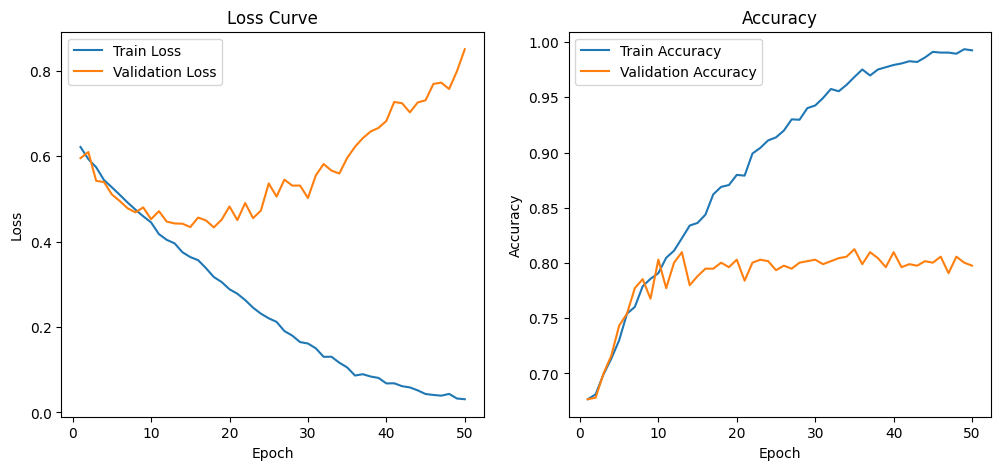

In [30]:
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.legend()

    plt.show()

plot_history(history)

In [31]:
def predict_image(model, img_path, transform, device="cpu"):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        pred = logits.argmax(dim=1).item()

    return pred, img

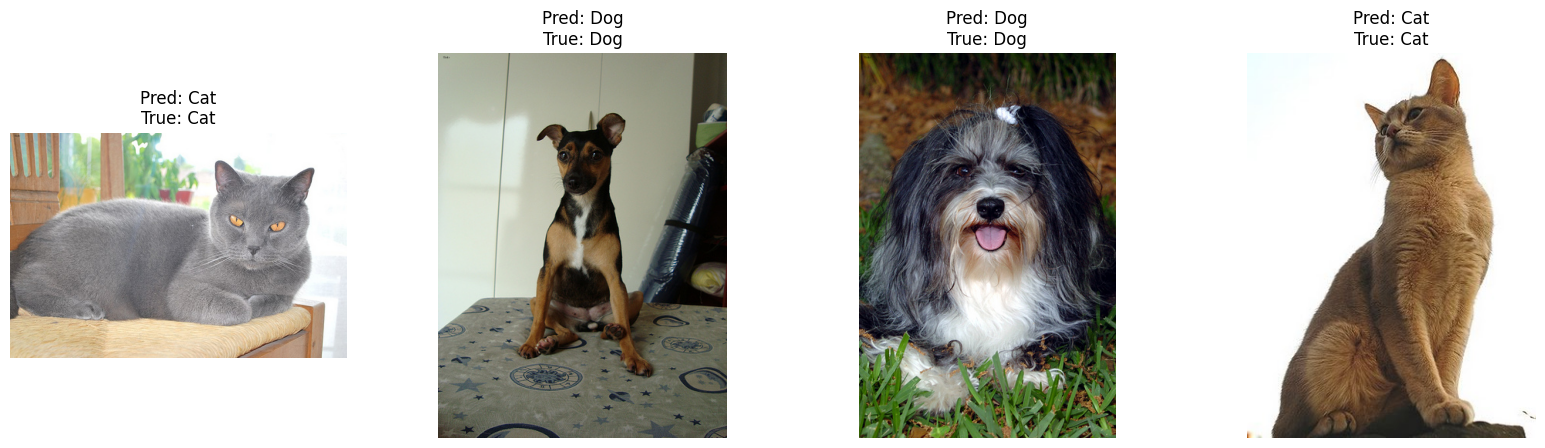

In [32]:
import random
label_map = {0: "Cat", 1: "Dog"}

def show_test_predictions(model, test_df, transform, num_samples=5, device="cpu"):
    samples = test_df.sample(num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(5 * num_samples, 5))

    if num_samples == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, samples.iterrows()):
        pred, img = predict_image(model, row["img_path"], transform, device)
        pred_label = label_map[pred]
        true_label = label_map[row["label"]]

        ax.imshow(img)
        ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}")
        ax.axis("off")

    plt.show()

show_test_predictions(model, test_df, val_transform, num_samples=4, device=device)


- More complex CNN (pretrained models ?)
- Confmat
- Save model weights
- 37-breeds classification
- Right evaluation metrics
- segmentation( U-Net, DeepLab etc)